<a href="https://colab.research.google.com/github/yelynn99/study-2020-2/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np # Linear algebra
import pandas as pd # For data manipulation
import json
import os
import matplotlib.pyplot as plt # For visualization
from sklearn.neighbors import KNeighborsClassifier # For modelling
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold # For evaluation and hyperparameter tuning
from sklearn.metrics import confusion_matrix, classification_report # For evaluation
from scipy.ndimage import shift, rotate, zoom # For data augmentation
from IPython.display import FileLink # For downloading the output file

for dirname, _, filenames in os.walk('/content/gdrive/My Drive/MNIST'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/gdrive/My Drive/MNIST/test.csv
/content/gdrive/My Drive/MNIST/sample_submission.csv
/content/gdrive/My Drive/MNIST/train.csv
/content/gdrive/My Drive/MNIST/MNIST.ipynb
/content/gdrive/My Drive/MNIST/knn(sklearn_datasets).ipynb


In [ ]:
train_df = pd.read_csv("/content/gdrive/My Drive/MNIST/train.csv")
test_df = pd.read_csv("/content/gdrive/My Drive/MNIST/test.csv")
submission_df = pd.read_csv("/content/gdrive/My Drive/MNIST/sample_submission.csv")

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [ ]:
X_train = train_df.iloc[:, 1:].values
y_train = train_df.iloc[:, 0].values
X_test = test_df.values

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (42000, 784)
y_train shape: (42000,)
X_test shape: (28000, 784)


Label: 9


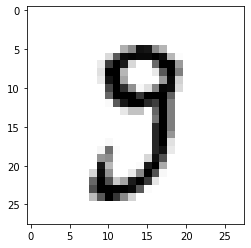

In [ ]:
some_digit = X_train[40]

some_digit_image = some_digit.reshape(28, 28)
print(f"Label: {y_train[40]}")
plt.imshow(some_digit_image, cmap="binary")
plt.show()

In [ ]:
stratified_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, indices in enumerate(stratified_fold.split(X_train, y_train)):
    # Creating datasets for training and testing the model 
    X_train_, y_train_ = X_train[indices[0]], y_train[indices[0]]
    X_test_, y_test_ = X_train[indices[1]], y_train[indices[1]]
    
    estimator = KNeighborsClassifier()
    estimator.fit(X_train_, y_train_)
    predictions = estimator.predict(X_test_)
    
    print(f"Classification report for Fold {fold + 1}:")
    print(classification_report(y_test_, predictions, digits=3), end="\n\n")
    
    print(f"Confusion Matrix for Fold {fold + 1}:")
    print(confusion_matrix(y_test_, predictions), end="\n\n")
    
    del X_train_
    del X_test_
    del y_train_
    del y_test_

NameError: ignored

In [ ]:
grid_params = {
    "weights": ['uniform', 'distance'],
    "n_neighbors": [3, 4, 5, 6, 8, 10]
}

estimator = KNeighborsClassifier()
grid_estimator = GridSearchCV(estimator, # Base estimator
                              grid_params, # Parameters to tune
                              cv=stratified_fold, # cross-validation stratergy
                              verbose=2, # Verbosity of the logs
                              n_jobs=-1) # Number of jobs to be run concurrently with -1 meaning all the processors


#Fitting the estimator with training data
grid_estimator.fit(X_train, y_train)

print(f"Best Score: {grid_estimator.best_score_}", end="\n\n")
print(f"Best Parameters: \n{json.dumps(grid_estimator.best_params_, indent=4)}",
       end="\n\n")
print("Grid Search CV results:")
results_df = pd.DataFrame(grid_estimator.cv_results_)
results_df

NameError: ignored

In [ ]:
estimator = KNeighborsClassifier(n_neighbors=4, weights='distance')
estimator.fit(X_train, y_train)
predictions = estimator.predict(X_test)

In [ ]:
def shift_in_one_direction(image, direction):
    """
    Shifts an image by one pixel in the specified direction
    """
    if direction == "DOWN":
        image = shift(image, [1, 0])
    elif direction == "UP":
        image = shift(image, [-1, 0])
    elif direction == "LEFT":
        image = shift(image, [0, -1])
    else:
        image = shift(image, [0, 1])

    return image


def shift_in_all_directions(image):
    """
    Shifts an image in all the directions by one pixel
    """
    reshaped_image = image.reshape(28, 28)

    down_shifted_image = shift_in_one_direction(reshaped_image, "DOWN")
    up_shifted_image = shift_in_one_direction(reshaped_image, "UP")
    left_shifted_image = shift_in_one_direction(reshaped_image, "LEFT")
    right_shifted_image = shift_in_one_direction(reshaped_image, "RIGHT")

    return (down_shifted_image, up_shifted_image,
            left_shifted_image, right_shifted_image)


def rotate_in_all_directions(image, angle):
    """
    Rotates an image clockwise and anti-clockwise
    """
    reshaped_image = image.reshape(28, 28)
    
    rotated_images = (rotate(reshaped_image, angle, reshape=False),
                      rotate(reshaped_image, -angle, reshape=False))
    
    return rotated_images


def clipped_zoom(image, zoom_ranges):
    """
    Clips and zooms an image at the specified zooming ranges
    """
    reshaped_image = image.reshape(28, 28)
    
    h, w = reshaped_image.shape
    
    zoomed_images = []
    for zoom_range in zoom_ranges:
        zh = int(np.round(h / zoom_range))
        zw = int(np.round(w / zoom_range))
        top = (h - zh) // 2
        left = (w - zw) // 2
        
        zoomed_images.append(zoom(reshaped_image[top:top+zh, left:left+zw],
                                  zoom_range))
    
    return zoomed_images

def alter_image(image):
    """
    Alters an image by shifting, rotating, and zooming it
    """
    shifted_images = shift_in_all_directions(image)
    rotated_images = rotate_in_all_directions(image, 10)
    zoomed_images = clipped_zoom(image, [1.1, 1.2])
            
    return np.r_[shifted_images, rotated_images, zoomed_images]

X_train_add = np.apply_along_axis(alter_image, 1, X_train).reshape(-1, 784)
y_train_add = np.repeat(y_train, 8)

print(f"X_train_add shape: {X_train_add.shape}")
print(f"y_train_add shape: {y_train_add.shape}")

In [ ]:
X_train_combined = np.r_[X_train, X_train_add]
y_train_combined = np.r_[y_train, y_train_add]

del X_train
del X_train_add
del y_train
del y_train_add

print(f"X_train_combined shape: {X_train_combined.shape}")
print(f"y_train_combined shape: {y_train_combined.shape}")

In [ ]:
cdata_estimator = KNeighborsClassifier(n_neighbors=4, weights='distance')
cdata_estimator.fit(X_train_combined, y_train_combined)
cdata_estimator_predictions = cdata_estimator.predict(X_test)

In [ ]:
submission_df["Label"] = predictions
submission_df.to_csv('submission.csv', index=False)
FileLink('submission.csv')

In [ ]:
submission_df["Label"] = cdata_estimator_predictions
submission_df.to_csv('cdata_submission.csv', index=False)
FileLink('cdata_submission.csv')